<a href="https://colab.research.google.com/github/Stefano-t/bioinf-lab/blob/main/k562_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# run this cell and the restart the runtime
!pip3 install -I numpy==1.21.0

     |████████████████████████████████| 15.7 MB 106 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!pip3 install -U tbb  &> /dev/null && echo "done"
!pip3 install -I humanize==3.9.0 numba==0.53.0 &> /dev/null && echo "done"
!pip3 install crr_labels epigenomic_dataset extra_keras_metrics \
    ucsc_genomes_downloader cache_decorator[all] minepy        \
    MulticoreTSNE &> /dev/null && echo "done"
!pip3 install keras_mixed_sequence keras_bed_sequence -U &> /dev/null && echo "done"

done
done
done
done


In [2]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
import seaborn as sbn
import typing as T

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Retrive epigenomic data

In [4]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 512

aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True,
    min_active_tpm_value=0,
    max_inactive_tpm_value=0,
)

apip_X, apip_y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True,
)

epigenomes = {
    "promoters": apip_X,
    "enhancers": aeie_X,
}

labels = {
    "promoters": apip_y,
    "enhancers": aeie_y,
}

# Retrive genomic sequence

In [5]:
from ucsc_genomes_downloader import Genome

genome = Genome(
    "hg38",
    cache_directory="/content/drive/MyDrive/bio-data/genomes"
)

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

# Describe dataset

## Explore sequence dataset

In [ ]:
# basic info

genome

Human, Homo sapiens, hg38, 2013-12-23, 25 chromosomes

In [ ]:
# sequence chromosomes
print("The chromosomes in the human genome are: {}.".format(", ".join(genome)))

The chromosomes in the human genome are: chr1, chrM, chr21, chr22, chrY, chr19, chr20, chr18, chr17, chr16, chr15, chr14, chr13, chr12, chr10, chr11, chr9, chr8, chrX, chr7, chr6, chr5, chr4, chr3, chr2.


In [ ]:
def to_bed(data: pd.DataFrame) -> pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
from keras_bed_sequence import BedSequence

def show_bed_sequence(genome: Genome,
                      dataset: pd.DataFrame,
                      region: str):
    # BedSequence one-hot encodes the genome sequence
    print("="*20, region.upper(), "="*20)
    seq = np.array(BedSequence(genome,
                               bed=to_bed(dataset),
                               batch_size=1))
    print(seq.shape)
    display(seq)


for region, X in epigenomes.items():
    show_bed_sequence(genome, X, region)

==================== PROMOTERS ====================


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(99881, 1, 512, 4)


array([[[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]],


       [[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
     

==================== ENHANCERS ====================
(63285, 1, 512, 4)


array([[[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]]],


       [[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
     

## Explore epigenomic dataset

In [ ]:
aeie_X

chrom                              SMAD5  NCOA2  ZNF23  ...  NCOR1  NCOA1  KLF1
chrom chromStart chromEnd  strand                       ...                    
chr10 100006253  100006765 .        0.94   0.99   1.07  ...   1.86   0.89  0.75
      100008018  100008530 .        0.72   1.23   0.60  ...   2.51   0.74  0.96
      100014290  100014802 .        0.56   0.40   0.52  ...   0.50   0.99  0.92
      100020088  100020600 .        0.98   0.96   0.81  ...   0.48   0.09  0.96
      100043400  100043912 .        0.86   0.68   0.12  ...   1.16   1.30  0.52
...                                  ...    ...    ...  ...    ...    ...   ...
chrY  7520119    7520631   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7724144    7724656   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7769901    7770413   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      7796167    7796679   .        0.00   0.00   0.00  ...   0.00   0.00  0.00
      8007434    8007946   .        0.00   0.00   0.00  ...   0.00   0.00  0.00

[63285 rows x 429 columns]

In [ ]:
aeie_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,STAG1,ZFX,STAT5A,E2F1,H2AFZ,TAL1,NFRKB,HNRNPUL1,SKIL,RBM34,ZBTB11,RBFOX2,ZNF175,GATA2,XRCC3,NFIC,ATF1,ETV6,ZNF444,MEF2D,ZNF700,SMARCA4,NFXL1,HMBOX1,IKZF1,TBX18,IRF2,H3K27ac,ZKSCAN8,PATZ1,...,ZEB2,KLF10,EP300,HDAC1,CEBPB,H3K4me1,ZNF319,SMARCE1,CBFA2T3,ZNF134,RUNX1,RNF2,TEAD1,MYC,ZNF148,ZNF766,HES1,MCM5,ZNF589,TARDBP,KLF6,ZNF583,ZNF696,PTRF,RFX5,UBTF,TEAD2,SMARCA5,HLTF,ZNF384,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63284.000000,63285.000000,63285.000000,63284.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.828114,0.749410,0.832911,0.794253,0.847651,0.815816,1.140897,0.907979,0.933537,0.999830,0.821321,0.863548,0.861133,0.948657,1.477279,1.023519,0.822428,0.974399,0.932441,0.760971,0.856852,1.432836,0.931714,1.065270,0.730274,0.895260,0.934184,0.915279,0.886615,0.988163,0.839588,1.067839,0.815479,1.015140,1.144816,0.955158,1.003804,2.110488,0.849224,0.874181,...,0.966820,0.807829,1.413646,1.111765,1.140694,2.021600,0.858906,1.150189,1.223522,0.912241,0.926078,0.894850,1.025447,1.445973,0.871832,0.864228,0.916312,0.831498,0.891243,0.972592,0.985386,1.002269,0.810231,0.828516,0.824648,0.945881,0.811613,0.899697,0.866454,1.233823,0.890387,0.956257,0.863282,1.294174,0.822257,0.641060,0.969684,1.018463,0.816725,0.932268
std,0.798612,0.284234,0.468083,0.271502,0.436767,0.406875,1.806344,0.403159,3.065108,1.789243,0.515187,0.761039,0.787038,2.783415,2.223694,2.620733,0.381663,0.482320,0.475806,0.487560,0.675240,5.525847,0.774866,1.030817,0.268060,1.490346,0.883519,0.608474,0.516538,0.909493,0.522392,0.780432,0.409572,1.365394,1.473356,0.571997,1.022278,5.428705,0.462599,0.399448,...,0.661262,0.310628,2.670049,0.887534,1.761020,2.945258,0.585571,1.081936,4.389130,0.835417,0.381465,0.531478,0.813395,2.605676,0.656072,0.611554,0.668960,0.358276,0.640281,0.497303,0.719716,0.649826,0.402027,0.429080,1.440661,0.771940,0.415712,0.501971,0.423483,2.042827,0.680888,0.663944,1.384189,1.889583,0.372946,0.405055,1.263316,1.384546,0.475728,0.480037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.510000,0.560000,0.520000,0.620000,0.570000,0.560000,0.370000,0.630000,0.480000,0.190000,0.460000,0.510000,0.530000,0.430000,0.320000,0.510000,0.570000,0.630000,0.610000,0.400000,0.640000,0.120000,0.490000,0.640000,0.550000,0.540000,0.630000,0.640000,0.55000

In [ ]:
aeie_y

K562
chrom chromStart chromEnd  strand       
chr10 100006253  100006765 .       False
      100008018  100008530 .       False
      100014290  100014802 .       False
      100020088  100020600 .       False
      100043400  100043912 .       False
...                                  ...
chrY  7520119    7520631   .       False
      7724144    7724656   .       False
      7769901    7770413   .       False
      7796167    7796679   .       False
      8007434    8007946   .       False

[63285 rows x 1 columns]

In [ ]:
aeie_y.describe()

,K562
count,63285
unique,2
top,False
freq,62884


In [ ]:
apip_X

chrom                              SMAD5  NCOA2  ZNF23  ...  NCOR1  NCOA1  KLF1
chrom chromStart chromEnd  strand                       ...                    
chr1  628708     629220    +        0.07   0.63   0.14  ...   0.90   1.11  1.06
      628757     629269    +        0.07   0.69   0.17  ...   0.98   1.23  1.08
      629386     629898    +        0.00   0.15   0.06  ...   0.14   0.32  0.15
      629591     630103    +        0.06   0.55   0.46  ...   0.20   0.38  0.45
      629649     630161    +        0.24   0.75   0.58  ...   0.27   0.39  0.62
...                                  ...    ...    ...  ...    ...    ...   ...
chrX  154441621  154442133 +        1.15   0.53   0.34  ...   0.44   0.39  0.64
      154584671  154585183 +        0.00   0.00   0.00  ...   0.00   0.00  0.00
chrY  1452882    1453394   -        0.00   0.00   0.00  ...   0.00   0.00  0.00
      2500959    2501471   -        0.00   0.00   0.00  ...   0.00   0.00  0.00
      14055717   14056229  +        0.00   0.00   0.00  ...   0.00   0.00  0.00

[99881 rows x 429 columns]

In [ ]:
apip_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,STAG1,ZFX,STAT5A,E2F1,H2AFZ,TAL1,NFRKB,HNRNPUL1,SKIL,RBM34,ZBTB11,RBFOX2,ZNF175,GATA2,XRCC3,NFIC,ATF1,ETV6,ZNF444,MEF2D,ZNF700,SMARCA4,NFXL1,HMBOX1,IKZF1,TBX18,IRF2,H3K27ac,ZKSCAN8,PATZ1,...,ZEB2,KLF10,EP300,HDAC1,CEBPB,H3K4me1,ZNF319,SMARCE1,CBFA2T3,ZNF134,RUNX1,RNF2,TEAD1,MYC,ZNF148,ZNF766,HES1,MCM5,ZNF589,TARDBP,KLF6,ZNF583,ZNF696,PTRF,RFX5,UBTF,TEAD2,SMARCA5,HLTF,ZNF384,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,...,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99878.000000,99880.000000,99881.000000,99881.000000,99881.000000,99878.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000
mean,1.972822,0.681448,0.921460,0.867284,1.159158,0.860483,3.257476,1.044810,6.233780,5.234981,0.943654,1.865069,0.971323,1.833795,3.822489,0.967534,1.053467,0.880989,1.294889,0.817111,1.694051,15.191921,0.992825,1.156540,0.643652,1.031783,2.222420,1.154852,1.061363,1.013228,0.896988,1.426588,0.774891,0.982149,1.473410,1.196991,1.769830,7.307502,0.801487,0.869921,...,1.164148,0.757464,2.187532,2.230668,1.375553,2.870853,0.948333,1.254667,1.073717,1.039215,1.126108,0.997571,1.269676,5.323621,1.171357,0.965458,1.006448,0.698768,0.958946,1.561774,1.205420,1.287191,0.797581,0.696791,1.325745,1.702800,0.733978,0.907875,1.008520,2.278856,2.118879,1.027485,1.478390,5.769136,0.858625,0.592426,2.449324,1.170722,0.762466,1.255991
std,2.242640,0.638053,0.530487,0.322646,1.611871,1.286303,4.191707,0.455288,16.745444,8.034981,0.496352,2.321489,0.691330,5.721369,4.338538,1.854054,0.916964,0.485619,0.857588,0.539637,4.883375,24.725184,0.631767,0.857526,0.257354,1.381222,4.103979,0.908415,0.704974,0.798989,0.587049,1.017965,0.907454,1.049887,1.857389,0.679227,2.353016,12.156544,0.426133,0.407180,...,1.265649,0.323197,2.729813,2.093633,2.060930,3.309274,1.275251,0.892956,3.032564,0.743118,0.451224,0.580665,0.974720,7.937788,1.113589,0.563567,0.807620,0.352235,0.551808,0.963988,0.853509,0.722932,0.479743,0.401182,3.334133,1.787917,0.442164,0.529802,0.529687,4.326858,2.288104,0.615356,5.347209,9.136453,0.433877,0.358293,11.539694,1.138718,0.410771,0.902976
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.630000,0.490000,0.540000,0.670000,0.640000,0.510000,0.730000,0.730000,0.580000,0.530000,0.620000,0.620000,0.570000,0.410000,0.520000,0.530000,0.600000,0.550000,0.700000,0.430000,0.720000,0.340000,0.570000,0.720000,0.480000,0.600000,0.720000,0.720000,0.

In [ ]:
apip_y

K562
chrom chromStart chromEnd  strand       
chr1  628708     629220    +       False
      628757     629269    +       False
      629386     629898    +       False
      629591     630103    +       False
      629649     630161    +        True
...                                  ...
chrX  154441621  154442133 +       False
      154584671  154585183 +       False
chrY  1452882    1453394   -       False
      2500959    2501471   -       False
      14055717   14056229  +       False

[99881 rows x 1 columns]

In [ ]:
apip_y.describe()

,K562
count,99881
unique,2
top,False
freq,78250


## Feature sample ratio

In [ ]:
for region, X in epigenomes.items():
    print(f"Feature sample ratio for {region} = {X.shape[0] / X.shape[1]}")

Feature sample ratio for promoters = 235.0141176470588
Feature sample ratio for enhancers = 149.60992907801418


## Nan detection

In [ ]:
for region, X in epigenomes.items():
    print(region)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")
    print("=" * 30)

promoters
Total NaN values: 0/42449425
Max NaN in a row: 0/425
Max NaN in a feature: 0/99881
enhancers
Total NaN values: 0/26769555
Max NaN in a row: 0/423
Max NaN in a feature: 0/63285


## Class balance

First, it is necessary to tranform boolean values into 0 and 1.

In [6]:
def binarize(y: pd.DataFrame, cell_line: str)-> pd.DataFrame:
    return y[cell_line].astype(int)

In [7]:
for region, y in labels.items():
    labels[region][cell_line] = binarize(y, cell_line)

Active-Inactive promoters ratio: 0.2764345047923323
Active fraction in promoters: 0.21656771558154203
Active-Inactive enhancers ratio: 0.09563546337494157
Active fraction in enhancers: 0.08728766690368966


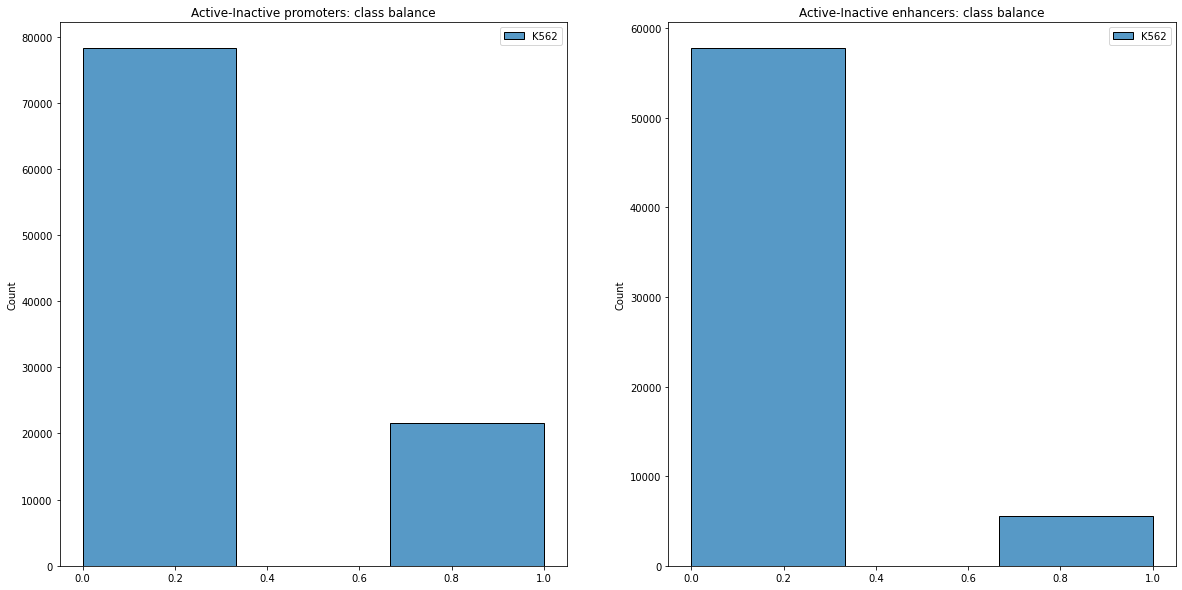

In [8]:
_, axs = plt.subplots(ncols=2, figsize=(20, 10))
for i, (region, y) in enumerate(labels.items()):
    axes = sbn.histplot(
        data=y,
        bins=3,
        ax=axs[i],
    )

    axes.set_title(f"Active-Inactive {region}: class balance")
    counts = y[cell_line].value_counts()
    print(f"Active-Inactive {region} ratio: {counts[1]/counts[0]}")
    print(f"Active fraction in {region}: {counts[1]/(counts[0]+counts[1])}")

# Data preprocessing

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler

def build_preprocess_pipeline() -> Pipeline:
    return Pipeline([("drop_costant_feature", VarianceThreshold()),
                     ("impute", SimpleImputer(strategy="median")),
                     ("scale", RobustScaler())])

In [10]:
preprocess_pipeline = build_preprocess_pipeline()
for region, X in epigenomes.items():
    index = X.index
    columns = X.columns
    epigenomes[region] = pd.DataFrame(data=preprocess_pipeline.fit_transform(X),
                                      index=index,
                                      columns=columns)

## Feature distribution

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_n_most_different(distances: np.ndarray, n: int) -> T.List[np.ndarray]:
    return np.argsort(-np.mean(distances, axis=1).flatten())[:n]

Top 5 different features from promoters.


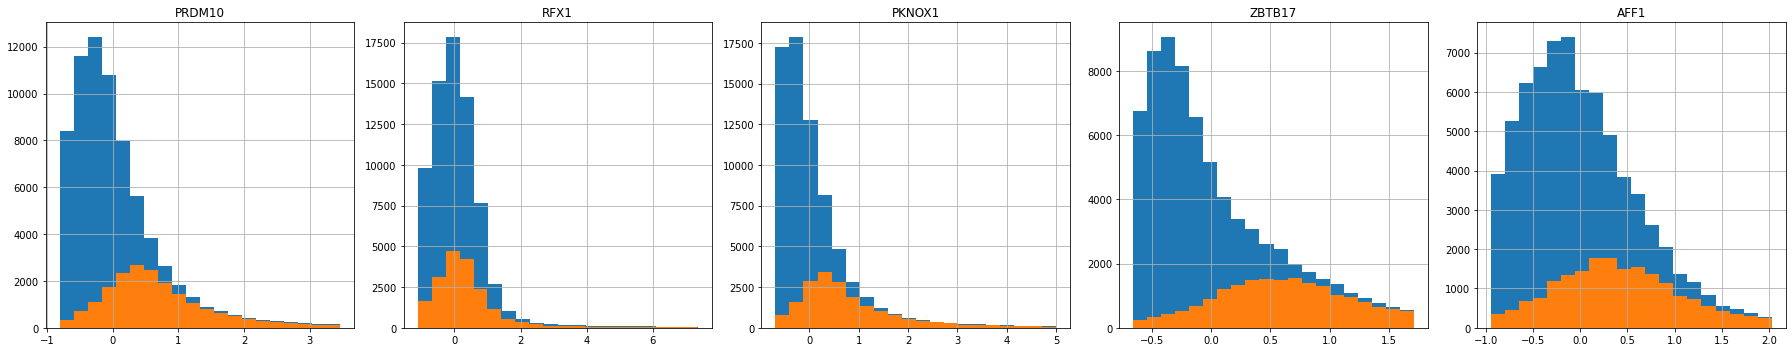

Top 5 different features from enhancers.


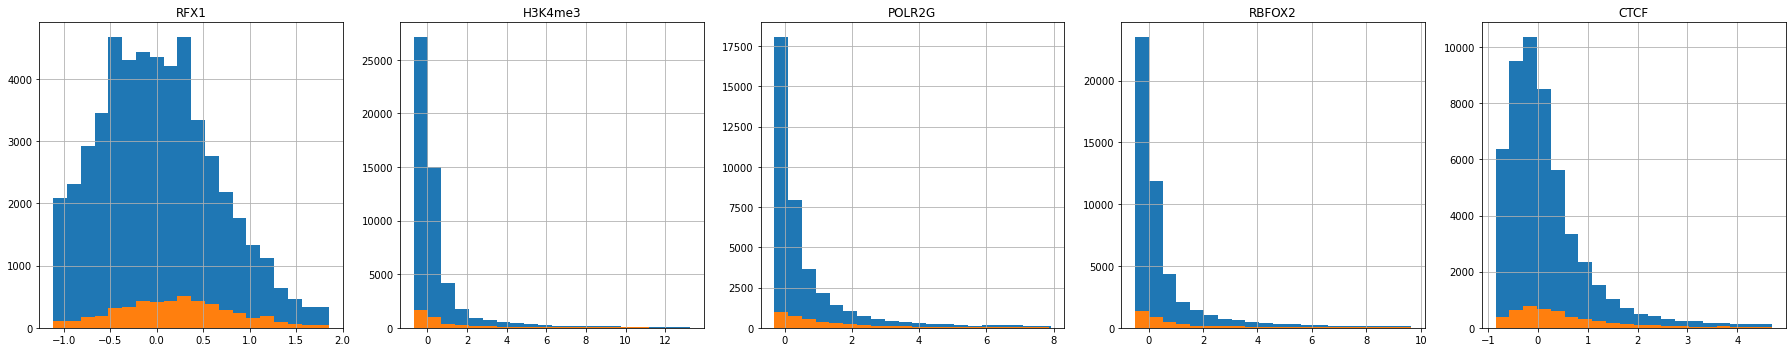

In [ ]:
top_number = 5

for region, X in epigenomes.items():
    dist = euclidean_distances(X.T)
    most_distance_columns_indices = get_n_most_different(dist, top_number)
    columns = X.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = X[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((X[column] < tail) & (X[column] > head)).values
        
        cleared_x = X[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

# Verify output correlation

In [ ]:
from scipy.stats import pearsonr

def pearson_corr_output(X: pd.DataFrame,
                        y: np.ndarray,
                        region: str,
                        p_value_threshold: float = 0.01) -> T.Set:
    uncorrelated_features_with_output = set()

    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [ ]:
from scipy.stats import spearmanr


def spearman_corr_output(X: pd.DataFrame,
                         y: np.ndarray,
                         region: str,
                         p_value_threshold: float = 0.01) -> T.Set:
    uncorrelated_features_with_output = set()
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [ ]:
from minepy import MINE

#@Cache(
    # cache_path="/content/drive/MyDrive/bio-data/outcorr/mine/{region}/{_hash}.pkl.gz",
    # args_to_ignore=["X", "y", "uncorrelated_features"]
# )
def mic_corr_output(X: pd.DataFrame,
                    y: np.ndarray,
                    region: str,
                    uncorrelated_features: T.Dict,
                    score_threshold: float = 0.05) -> T.Dict:
    for feature in tqdm(uncorrelated_features[region],
                        desc = f"Running MINE test for {region}",
                        dynamic_ncols = True,
                        leave = False):
        mine = MINE()
        mine.compute_score(X[feature].values.ravel(), y)
        score = mine.mic()
        if score >= score_threshold:
            print(f"{feature} is not correlated for")
            uncorrelated_features[region].remove(feature)

    return uncorrelated_features

In [ ]:
uncorrelated_features_with_output = {
    region: set()
    for region in epigenomes.keys()
}

for region, X in epigenomes.items():
    uncorrelated_features_with_output[region] = pearson_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )
    uncorrelated_features_with_output[region] = spearman_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )

print(f"The following features have no correlation with the output: {uncorrelated_features_with_output}")

The following features have no correlation with the output: {'promoters': {'ZBTB8A', 'KLF10', 'PRMT5', 'FOXA1'}, 'enhancers': {'SUZ12', 'U2AF2', 'SRSF7', 'FOXJ3', 'RBM17', 'EWSR1'}}


In [ ]:
for region, X in epigenomes.items():
    uncorrelated_features_with_output = mic_corr_output(
        X,
        labels[region].values.ravel(),
        region,
        uncorrelated_features_with_output,
    )

In [ ]:
for region, X in epigenomes.items():
    last_shape = X.shape
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])
    print(f"{region} now has shape {epigenomes[region].shape} (last was {last_shape})")

promoters now has shape (99881, 425) (last was (99881, 429))
enhancers now has shape (63285, 423) (last was (63285, 429))


# Feature Correlation

In [ ]:
from scipy.stats import entropy
from scipy.stats import pearsonr
from typing import List

def features_correlation(X: pd.DataFrame, region: str) -> List:
    scores = []

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores.append((correlation, p_value, feature_1, feature_2))

    return scores

In [ ]:
feature_corr_scores = {
    region: list()
    for region in epigenomes.keys()
}

for region, X in epigenomes.items():
    feature_corr_scores[region] = features_correlation(X, region)

In [ ]:
# sort features by decreasing correlation

feature_corr_scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in feature_corr_scores.items()
}

Most correlated features from promoters
Most correlated features from enhancers


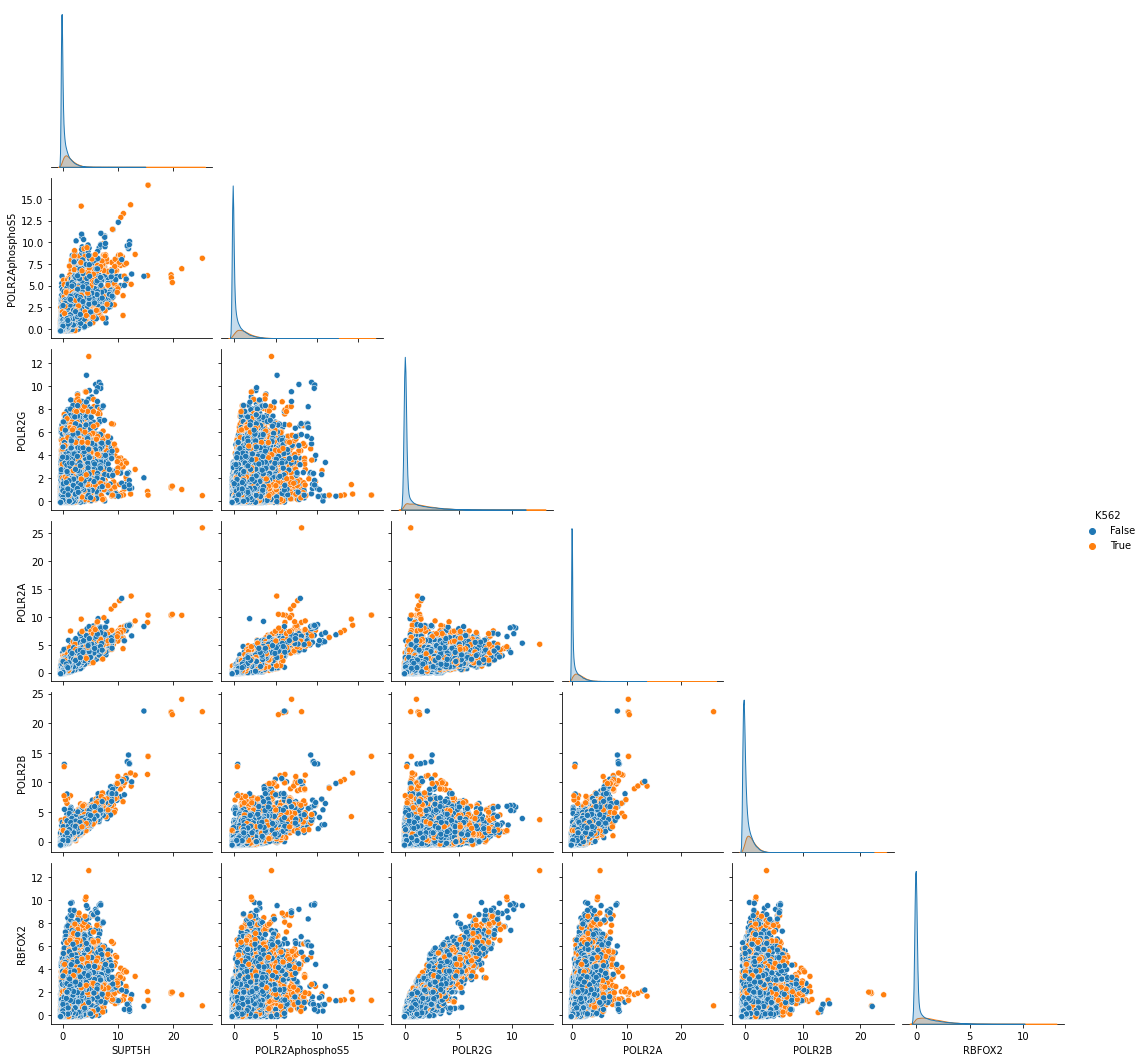

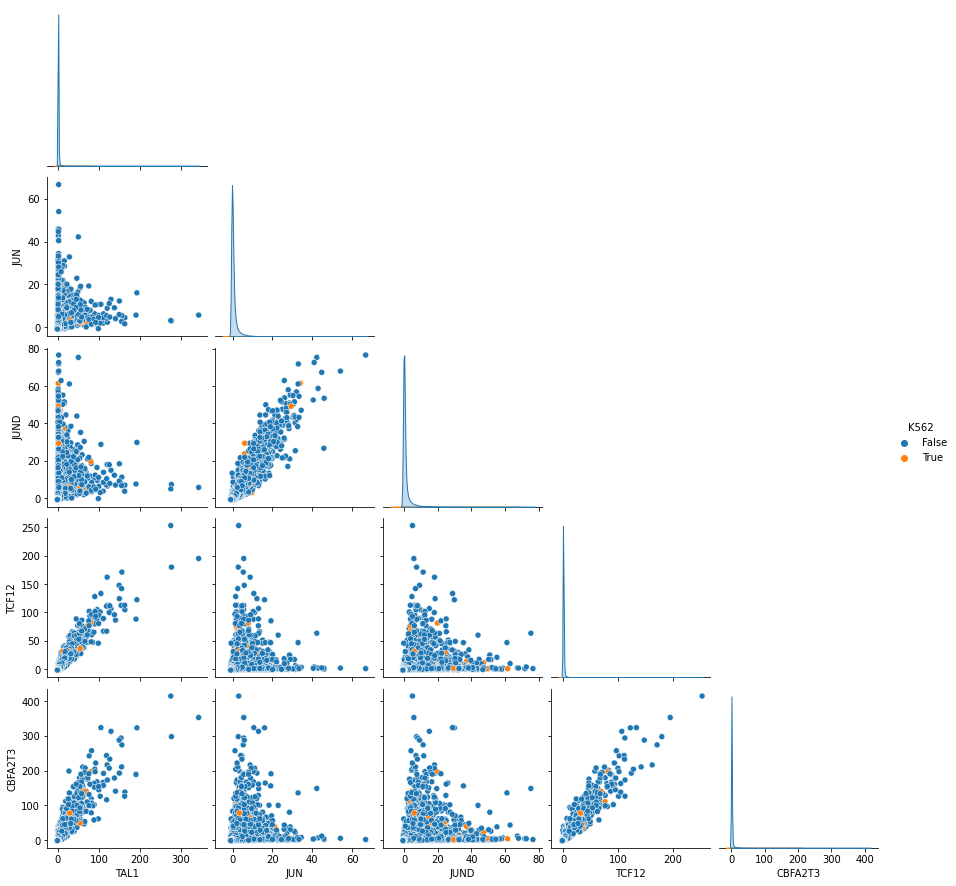

In [ ]:
for region, X in epigenomes.items():
    # creates the cartesian product between the top three correlated features
    _, _, firsts, seconds = list(zip(*feature_corr_scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region}")
    sbn.pairplot(pd.concat([X[columns], labels[region]], axis=1),
                 hue=labels[region].columns[0],
                 corner=True)

In [ ]:
correlation_threshold = 0.95
p_value_threshold = 0.01

for region, X in epigenomes.items():
    last_shape = X.shape
    high_correlation = [
        (item[2], item[3])
        for item in feature_corr_scores[region]
        if item[0] > correlation_threshold and item[1] < p_value_threshold
    ]
    to_drop = []
    for f1, f2 in high_correlation:
        if entropy(X[f1]) > entropy(X[f2]):
            to_drop.append(f2)
        else:
            to_drop.append(f1)

    epigenomes[region] = X.drop(to_drop, axis=1)
    print(f"Dropping {to_drop} from {region} dataset...")
    print(f"New shape: {epigenomes[region].shape} (was {last_shape})")

Dropping ['RBFOX2'] from promoters dataset...
New shape: (99881, 428) (was (99881, 429))
Dropping [] from enhancers dataset...
New shape: (63285, 429) (was (63285, 429))


# Feature selection

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE
from multiprocess import cpu_count

#@Cache(
#    cache_path="/content/drive/MyDrive/bio-data/featuresel/{region}/{holdout_number}/{n_features}_{deletion_step}/{_hash}.csv.gz",
#    args_to_ignore=["X","y"]
#)
def recursive_feature_elimination_with_sgd(X: pd.DataFrame,
                                           y: np.ndarray,
                                           region: str,
                                           holdout_number: int,
                                           n_features: int = 50,
                                           deletion_step: int = 10,
                                           verbose: int = 0) -> pd.DataFrame:
    clf = SGDClassifier(loss="log",
                        penalty="l1",
                        #verbose=1,
                        n_jobs=cpu_count(),
                        early_stopping=True,
                        class_weight="balanced")
    rfe = RFE(clf,
              n_features_to_select=n_features,
              step=deletion_step,
              verbose=verbose)
    rfe = rfe.fit(X, y)
    X_new = pd.DataFrame(rfe.transform(X),
                         columns=X.columns[rfe.get_support()],
                         index=X.index)
    return X_new

# Data visualization

In [11]:
from sklearn.decomposition import PCA

def pca_decomposition(X: np.ndarray, components: int = 2) -> np.ndarray:
    return PCA(n_components=components, random_state=1234).fit_transform(X)

In [12]:
from MulticoreTSNE import MulticoreTSNE as TSNE

@Cache(
    cache_path="decomposition/tsne/{task}/{perplexity}_{dimensionality_threshold}_{_hash}.pkl.gz",
    args_to_ignore=["X"]
)
def tsne_decomposition(X:np.ndarray,
                       perplexity:int,
                       task:str,
                       dimensionality_threshold:int=50) -> np.ndarray:
    if X.shape[1] > dimensionality_threshold:
        X = pca_decomposition(X, components=dimensionality_threshold)
    return TSNE(
        perplexity=perplexity,
        n_jobs=cpu_count(),
        random_state=42
    ).fit_transform(X)

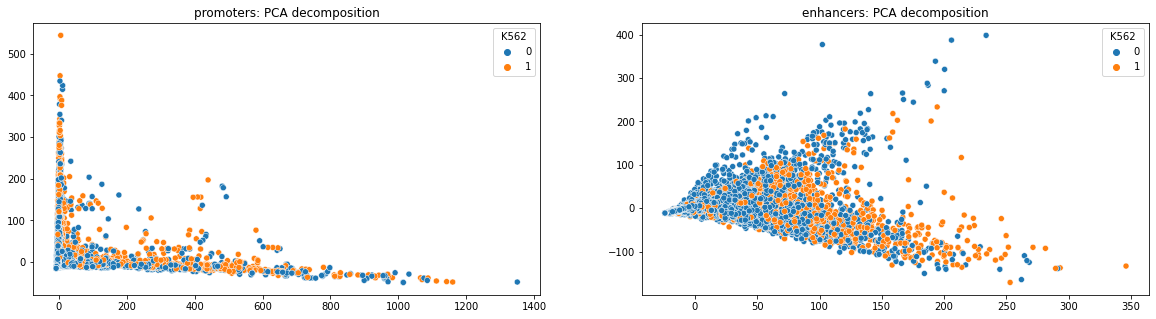

In [17]:
_, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 5)
)

# PCA decomposition
for i, (region, X) in enumerate(epigenomes.items()):
    pca_dec = pca_decomposition(X.values)
#    tsne_dec = tsne_decomposition(
#        X.values,
#        perplexity=30,
#        task=region,
#        dimensionality_threshold=50,
#    )
    
    ax = sbn.scatterplot(
        x=pca_dec.T[0],
        y=pca_dec.T[1],
        hue=labels[region][cell_line],
        ax=axs[i]
    )
    ax.set_title(f"{region}: PCA decomposition")
    
    # ax = sbn.scatterplot(
    #     x=tsne_dec.T[0],
    #     y=tsne_dec.T[1],
    #     hue=labels[region][cell_line],
    #     ax=axs[i][1]
    # )
    # ax.set_title(f"{region}: TSNE decomposition")

In [19]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(10, 10)
)
for i, (region, X) in enumerate(epigenomes.items()):
    for j, perplexity in enumerate((30, 40, 50)):
        tsne_dec = tsne_decomposition(X.values,
                                      perplexity=perplexity,
                                      task=region,
                                      dimensionality_threshold=50)
        ax = sbn.scatterplot(x=tsne_dec.T[0],
                             y=tsne_dec.T[1],
                             hue=labels[region][cell_line],
                             ax=axs[i][j])
        ax.set_title(
            f"{region}: TSNE decomposition with perplexity {perplexity}")

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd3495f7c20> (for post_execute):


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fd349600290> (for post_execute):


KeyboardInterrupt: ignored

# Model evaluation

In [ ]:
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

def evaluate_all_model_prediction(y_train_true: np.ndarray,
                                  y_train_pred: np.ndarray,
                                  y_test_true: np.ndarray,
                                  y_test_pred: np.ndarray,
                                  model_name: str,
                                  task_name: str,
                                  holdout_number: int,
                                  use_feature_selection: bool,
) -> T.Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    task_name: str,
        Name of the task to work with.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features selection or not.

    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "task_name": task_name,
        "holdout_number": holdout_number,
        "use_feature_selection": "Yes" if use_feature_selection else "No",
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations
        },
    ]


def evaluate_model_prediction(y_true: np.ndarray,
                              y_pred: np.ndarray)-> T.Dict[str, float]:
    """Returns the evaluation of the given predictions.

    By default, this method evaluates accuracy, AUROC and AUPRC.

    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(
                y_true, 
                np.round(y_pred).astype(int)
            )
            for metric in int_metrics
        }
    }

In [ ]:
from typing import Union
from tensorflow.keras.models import Model
from keras_mixed_sequence import MixedSequence, VectorSequence
from sklearn.ensemble import RandomForestClassifier

@Cache(
    cache_path="/content/drive/MyDrive/bio-data/training/{predictor_name}/{task_name}_{holdout_number}/{use_feature_selection}_{_hash}.csv.gz",
    args_to_ignore=["predictor", "X_train", "X_test", "y_train", "y_test"]
)
def train_random_forest(predictor: RandomForestClassifier,
                        X_train: np.ndarray,
                        y_train: np.ndarray,
                        X_test: np.ndarray,
                        y_test: np.ndarray,
                        task_name: str,
                        predictor_name: str,
                        holdout_number: int,
                        use_feature_selection: bool)-> pd.DataFrame:
    """Trains and evaluates the given predictor.
    
    By defualt, this method evaluates accuracy, AUROC and AUPRC on the test set.

    Args:
        predictor: A sklearn RandomModelClassifier to train.
        X_train: The training set.
        y_train: The labels corresponding to the training set.
        X_test: The test set.
        y_test: The labels corresponding to the test set.
        task_name: The name of the task where the predictor is trained on.
        predictor_name: The name of the predictor.
        holdout_number: The number of the holdout currently taken.
        use_feature_selection: Wheter the predictor is trained on a reduced 
          dataset.

    Returns:
        A dict where the keys are the name of the metrics ("accuracy", "AUROC",
        "AUPRC"), and the values are the respective scores.
    """
    
    predictor.fit(X_train, y_train)

    y_train_prediction = predictor.predict(X_train)
    y_test_prediction = predictor.predict(X_test)
    
    return pd.DataFrame(evaluate_all_model_prediction(
        y_train, y_train_prediction,
        y_test, y_test_prediction,
        predictor_name,
        task_name,
        holdout_number,
        use_feature_selection
    ))

In [ ]:
from typing import Tuple

@Cache(
    cache_path="/content/drive/MyDrive/bio-data/training/{model_name}/{task}_{holdout_number}/{use_feature_selection}_{_hash}.csv.gz",
    args_to_ignore=["training_sequence", "model", "test_sequence"]
)
def train_model(model: Model,
                model_name: str,
                task: str,
                training_sequence: MixedSequence,
                test_sequence: MixedSequence,
                holdout_number: int,
                use_feature_selection: bool) -> pd.DataFrame:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    model.fit(
        training_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
                EarlyStopping("loss", min_delta=1e-3, patience=2, mode="min")
        ]
    )
    
    train_evaluation = dict(zip(model.metrics_names,
                                model.evaluate(training_sequence,
                                               verbose=False)))
    test_evaluation = dict(zip(model.metrics_names,
                               model.evaluate(test_sequence, verbose=False)))
    
    common_informations = {
        "model_name": model_name,
        "task_name": task,
        "holdout_number": holdout_number,
        "use_feature_selection": "Yes" if use_feature_selection else "No",
    }
        
    return pd.DataFrame([
        {
            **train_evaluation,
            "run_type": "train",
            **common_informations
        },
        {
            **test_evaluation,
            "run_type": "test",
            **common_informations
        },
    ])

# Model creation

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer, Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_complete_binary_metrics, get_standard_binary_metrics,get_minimal_multiclass_metrics

from tqdm.keras import TqdmCallback
from keras_bed_sequence import BedSequence

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from multiprocess import cpu_count

def build_random_forest(n_estimators: int = 100,
                        max_depth: int = 5,
                        min_samples_leaf: int = 100,
                        verbose: bool = False,
                        random_state: int = 12345) -> RandomForestClassifier:
    return RandomForestClassifier(
        class_weight="balanced_subsample",
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=cpu_count(),
        verbose=verbose,
        random_state=random_state,
    )

## Feed-Forward Neural Network

In [ ]:
def build_fixed_ffnn(input_shape: int,
                     regression: bool)-> T.Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(256, activation="relu")(input_epigenomic_data)
    hidden = Dense(128, activation="relu")(hidden)
    last_hidden_ffnn = Dense(64, activation="relu")(hidden)
    if regression:
        output_ffnn = Dense(1, activation="linear")(last_hidden_ffnn)
    else:
        output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="RegressionFFNN" if regression else "BinaryFixedFFNN"
    )

    ffnn.compile(
        optimizer=SGD(
            learning_rate=0.1
        ),
        loss="mse" if regression else "binary_crossentropy",
        metrics=["mse"] if regression else get_minimal_multiclass_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

## CNN

In [ ]:
def build_fixed_cnn(window_size: int,
                    regression: bool) -> T.Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """

    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(32, kernel_size=4, activation="relu")(hidden)
        #hidden = Dropout(rate=0.1)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
    
    hidden = GlobalAveragePooling1D()(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(32, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.2)(hidden)
    if regression:
        output_cnn = Dense(1, activation="linear")(last_hidden_cnn)
    else:
        output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="RegressionCNN" if regression else "BinaryClassificationCNN",
    )

    cnn.compile(
        optimizer=Nadam(learning_rate=0.002),
        loss="mse" if regression else "binary_crossentropy",
        metrics=["mse"] if regression else get_minimal_multiclass_metrics(),
    )

    return cnn, input_sequence_data, last_hidden_cnn

## Multi Modal Neural Network

In [ ]:
from typing import Optional

def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
    regression: bool = False,
)-> Model:
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    The created model.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(
            input_shape,
            regression)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size,
                                                                  regression)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    if regression:
        output_mmnn = Dense(1, activation="linear")(last_hidden_mmnn)
    else:
        output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    name = []
    if regression:
        name.append("Regression")
    if input_shape is None:
        name.append("BoostedMMNN")
    else:
        name.append("MMNN")

    mmnn = Model(inputs=[input_epigenomic_data, input_sequence_data],
                 outputs=output_mmnn,
                 name=''.join(name))

    mmnn.compile(
        optimizer="nadam",
        loss="mse" if regression else "binary_crossentropy",
        metrics=["mse"] if regression else get_minimal_multiclass_metrics()
    )

    return mmnn

## Create input sequence

In [ ]:
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(X: np.ndarray,
                      y: np.ndarray,
                      batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_cnn_sequence(genome: Genome,
                     bed: pd.DataFrame,
                     y: np.ndarray,
                     batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(genome: Genome,
                      bed: pd.DataFrame,
                      X: np.ndarray,
                      y: np.ndarray,
                      batch_size: int = 1024) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

# Train and evaluate the models

In [ ]:
#from collections.abc import Callable

@Cache(
    cache_path="/content/drive/MyDrive/bio-data/seqAndTraining/{predictor_name}/{task_name}_{holdout_number}/{feature_selection}_{_hash}.csv.gz",
    args_to_ignore=["predictor", "X_train", "X_test", "y_train", "y_test", "genome", "train_bed", "test_bed", "f_get_sequence"]
)
def create_seq_and_evaluate_model(
        X_train: T.Optional[np.ndarray],
        X_test: T.Optional[np.ndarray],
        genome: T.Optional[Genome],
        train_bed: T.Optional[BedSequence],
        test_bed: T.Optional[BedSequence],
        y_train: np.ndarray,
        y_test: np.ndarray,
        predictor: Model,
        predictor_name: str,
        f_get_sequence: T.Callable[[np.ndarray, np.ndarray, int], MixedSequence],
        task_name: str,
        holdout_number: int,
        feature_selection: bool,
        batch_size: int = 1024,
) -> pd.DataFrame:
    if X_train is None and X_test is None: # train a cnn
        if genome is None or train_bed is None or test_bed is None:
            # error, in this branch all the three elements must be supplied
            raise ValueError("To train a CNN, genome, train_bed and test_bed"
                             " must be supplied.")
        train_seq = f_get_sequence(genome, train_bed, y_train, batch_size)
        test_seq = f_get_sequence(genome, test_bed, y_test, batch_size)
    elif X_train is not None and X_test is not None:
        if genome is None and train_bed is None and test_bed is None:
            # we want to train a ffnn
            train_seq = f_get_sequence(X_train, y_train, batch_size)
            test_seq = f_get_sequence(X_test, y_test, batch_size)
        elif (genome is not None and train_bed is not None
                 and test_bed is not None):
            # we want to train a mmnn
            train_seq = f_get_sequence(genome, train_bed, X_train, y_train)
            test_seq = f_get_sequence(genome, test_bed, X_test, y_test)
        else:
            raise ValueError("When X_train and X_test are supplied, genome, "
                             "train_bed and test_bed must be either supplied"
                             "or not.")
    else:
        raise ValueError("The combination of input is not correct. Please refer"
                         " to the docstring for further explanations.")

    return train_model(predictor,
                       predictor.name,
                       task_name,
                       train_seq,
                       test_seq,
                       holdout_number,
                       feature_selection)


First, retrive again the datasets to remove any kind of data leakege.

In [ ]:
aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

apip_X, apip_y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

epigenomes = {
    "promoters": apip_X,
    "enhancers": aeie_X,
}

labels = {
    "promoters": binarize(apip_y, cell_line),
    "enhancers": binarize(aeie_y, cell_line),
}

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 10
test_size = 0.2
random_state = 9012

stratified_split = StratifiedShuffleSplit(n_splits = n_splits,
                                          test_size = test_size,
                                          random_state = random_state)

In [ ]:
all_performance_classification = {}

preprocess = build_preprocess_pipeline()

for task_name, X in epigenomes.items():
    bed = to_bed(X)
    all_performance_classification[task_name] = []
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(stratified_split.split(X, labels[task_name])),
        total=n_splits,
        leave=False,
        desc="Computing holdouts for {}".format(task_name)
    ):
        # all_performance_classification[task_name] + loop_body(
        #    X,
        #    labels,
        #    genome,
        #    task_name,
        #    bed,
        #    holdout_number,
        #    train_indices,
        #    test_indices,
        # )
       # train and test set
       train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
       X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
       y_train, y_test = (labels[task_name].iloc[train_indices],
                          labels[task_name].iloc[test_indices])

       train_index = X_train.index
       train_columns = X_train.columns
       test_index = X_test.index
       test_columns = X_test.columns
       X_train = pd.DataFrame(data=preprocess.fit_transform(X_train),
                              index=train_index,
                              columns=train_columns)
       X_test =  pd.DataFrame(data=preprocess.transform(X_test),
                              index=test_index,
                              columns=test_columns)
       y_train = y_train.values.flatten()
       y_test = y_test.values.flatten()

       for feature_selection in (False, True):
           if feature_selection:
               X_train = recursive_feature_elimination_with_sgd(X_train,
                                                                y_train,
                                                                task_name,
                                                                holdout_number,
                                                                n_features=250)
               X_test = X_test[X_train.columns]
           
           # creation of the models
           random_forest = build_random_forest()
           ffnn, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(
               X_train.shape[1], False)
           cnn, input_sequence_data, last_hidden_cnn = build_fixed_cnn(
               X_train.shape[1], False)
           mmnn1 = build_binary_classification_mmnn(
               input_shape=X_train.shape[1], 
               window_size=window_size,
               regression=False)
           mmnn2 = build_binary_classification_mmnn(
               input_sequence_data=input_sequence_data,
               input_epigenomic_data=input_epigenomic_data,
               last_hidden_ffnn=last_hidden_ffnn,
               last_hidden_cnn=last_hidden_cnn,
               regression=False,
           )
           #if holdout_number == 0 and not feature_selection: 
           #    cnn.summary()
           #    ffnn.summary()
           #    mmnn1.summary()
           #    mmnn2.summary()

           # Train firstly the random forest because it uses a different 
           # method.
           performance = train_random_forest(random_forest,
                                             X_train.values,
                                             y_train,
                                             X_test.values,
                                             y_test,
                                             task_name,
                                             "RandomForest",
                                             holdout_number,
                                             feature_selection)

           all_performance_classification[task_name].append(performance)

           # Now, train the neural network models.
           for predictor, train_x, test_x, genome, bed_train, bed_test, f_get_sequence in tqdm(
               ((ffnn, X_train.values, X_test.values, None, None, None, 
                 get_ffnn_sequence),
                (cnn, None, None, genome, train_bed, test_bed, 
                 get_cnn_sequence),
                (mmnn1, X_train.values, X_test.values, genome, train_bed,
                 test_bed, get_mmnn_sequence),
                (mmnn2, X_train.values, X_test.values, genome, train_bed, 
                 test_bed, get_mmnn_sequence),
               ),
               desc="Training models",
               leave=False,
           ):
               performance = create_seq_and_evaluate_model(
                   train_x, 
                   test_x,
                   genome,
                   bed_train,
                   bed_test,
                   y_train,
                   y_test,
                   predictor,
                   predictor.name,
                   f_get_sequence,
                   task_name,
                   holdout_number,
                   feature_selection,
               )
               all_performance_classification[task_name].append(performance)
           

    all_performance_classification[task_name] = pd.concat(
        all_performance_classification[task_name])

Computing holdouts for promoters:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdouts for enhancers:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display

# join the 'accuracy' columns, since training a Keras Model and a Random Forest
# gives diffent names for the same metric.
for region, X in all_performance_classification.items():
    print(region.upper())
    X["accuracy"] = X["accuracy"].fillna(0) + X["Accuracy"].fillna(0)
    X.reset_index(drop=True, inplace=True)
    X.drop(["Accuracy", "loss", "recall", "precision"],
           axis=1,
           inplace=True,
           errors="ignore")
    display(X)


PROMOTERS


,AUPRC,AUROC,run_type,model_name,task_name,holdout_number,use_feature_selection,accuracy
0,0.475755,0.826345,train,RandomForest,promoters,0,No,0.788671
1,0.487735,0.833280,test,RandomForest,promoters,0,No,0.797868
2,0.769559,0.927641,train,BinaryFixedFFNN,promoters,0,No,0.871771
3,0.652586,0.900816,test,BinaryFixedFFNN,promoters,0,No,0.845272
4,0.455868,0.776094,train,BinaryClassificationCNN,promoters,0,No,0.789648
...,...,...,...,...,...,...,...,...
195,0.471068,0.781994,test,BinaryClassificationCNN,promoters,9,Yes,0.793262
196,0.907792,0.975818,train,MMNN,promoters,9,Yes,0.924447
197,0.636198,0.885543,test,MMNN,promoters,9,Yes,0.841818
198,0.944520,0.983919,train,BoostedMMNN,promoters,9,Yes,0.939127


ENHANCERS


,AUPRC,AUROC,run_type,model_name,task_name,holdout_number,use_feature_selection,accuracy
0,0.180505,0.733433,train,RandomForest,enhancers,0,No,0.753615
1,0.178729,0.728681,test,RandomForest,enhancers,0,No,0.757209
2,0.590649,0.897135,train,BinaryFixedFFNN,enhancers,0,No,0.928854
3,0.292667,0.759181,test,BinaryFixedFFNN,enhancers,0,No,0.913092
4,0.113205,0.557378,train,BinaryClassificationCNN,enhancers,0,No,0.912716
...,...,...,...,...,...,...,...,...
195,0.126482,0.583576,test,BinaryClassificationCNN,enhancers,9,Yes,0.912697
196,0.972446,0.996709,train,MMNN,enhancers,9,Yes,0.981848
197,0.221650,0.691528,test,MMNN,enhancers,9,Yes,0.899028
198,0.973854,0.996649,train,BoostedMMNN,enhancers,9,Yes,0.985028


## Barplot

Plot the performance of all the predictors in train and test set.

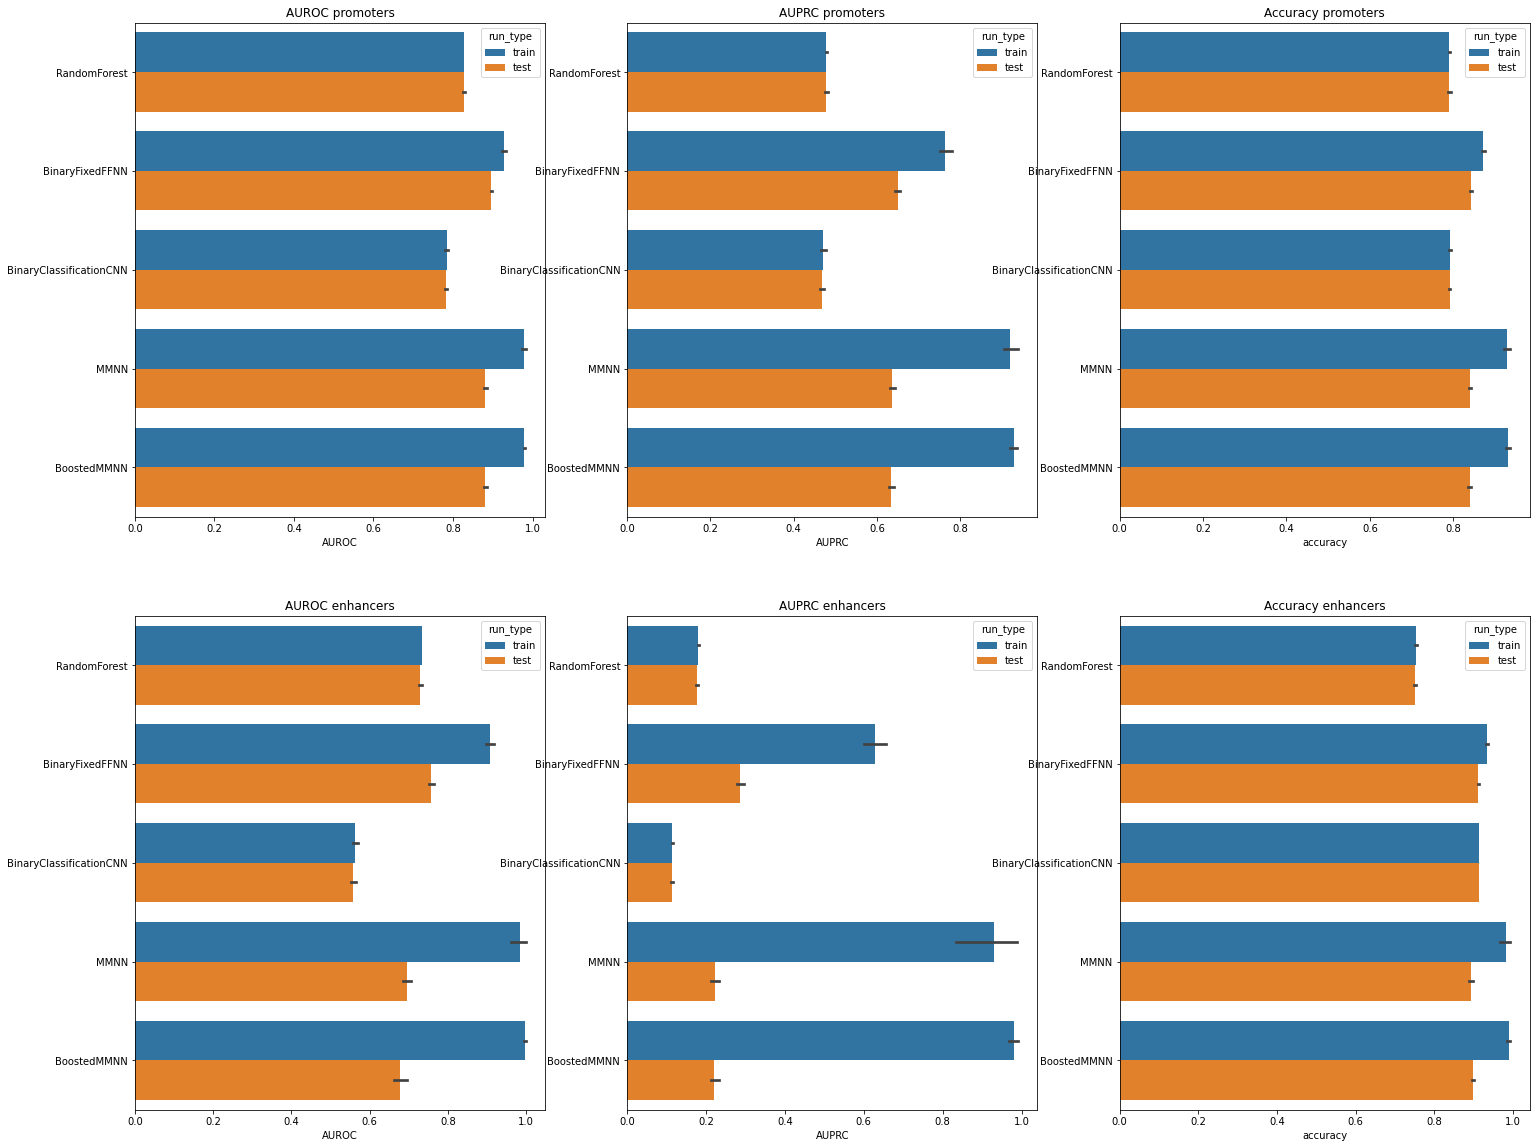

In [ ]:
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 20), squeeze=True)

for i, (task_name, dataframe) in enumerate(
    all_performance_classification.items()
):
    without_fs = dataframe[(dataframe.use_feature_selection == "No") | 
                           (dataframe.use_feature_selection == False)]
    sbn.barplot(x="AUROC",
                y="model_name",
                data=without_fs,
                hue="run_type",
                orient="h",
                ax=axs[i][0])
    _ = axs[i][0].set_title(f"AUROC {task_name}")
    axs[i][0].set_ylabel("")
    
    sbn.barplot(x="AUPRC",
                y="model_name",
                data=without_fs,
                hue="run_type",
                orient="h",
                ax=axs[i][1])
    _ = axs[i][1].set_title(f"AUPRC {task_name}")
    axs[i][1].set_ylabel("")
    
    sbn.barplot(x="accuracy",
                y="model_name",
                data=without_fs,
                hue="run_type",
                orient="h",
                ax=axs[i][2])
    _ = axs[i][2].set_title(f"Accuracy {task_name}")
    axs[i][2].set_ylabel("")

# Wilcoxon test

In [ ]:
from scipy.stats import wilcoxon

First, compare the test on the performance of the same model with and without feature selection.

In [ ]:
# test if the models perform better with feature selection or not
for region, X in all_performance_classification.items():
    print(region.upper())

    for model in X.model_name.unique():
        test_performance = X[(X.model_name == model) & (X.run_type == "test")]
        performance_with_feature_selection = test_performance[
            X.use_feature_selection == "Yes"
        ]
        performance_without_feature_selection = test_performance[
            X.use_feature_selection == "No"
        ]
        print(f"comparing {model}")
        for metric in ("AUPRC", "AUROC", "accuracy"):
            try:
                print(model,
                      metric,
                      wilcoxon(performance_with_feature_selection[metric],
                               performance_without_feature_selection[metric]))
            except ValueError:
                print(f"{model} has the same values for {metric}")

PROMOTERS
comparing RandomForest
RandomForest AUPRC WilcoxonResult(statistic=12.0, pvalue=0.11412832776223863)
RandomForest AUROC WilcoxonResult(statistic=11.0, pvalue=0.09260069782067576)
RandomForest accuracy WilcoxonResult(statistic=14.0, pvalue=0.1685302345363282)
comparing BinaryFixedFFNN
BinaryFixedFFNN AUPRC WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)
BinaryFixedFFNN AUROC WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
BinaryFixedFFNN accuracy WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
comparing BinaryClassificationCNN
BinaryClassificationCNN AUPRC WilcoxonResult(statistic=8.0, pvalue=0.04685328478814715)
BinaryClassificationCNN AUROC WilcoxonResult(statistic=7.0, pvalue=0.03665792867221451)
BinaryClassificationCNN accuracy WilcoxonResult(statistic=15.0, pvalue=0.20262160771231197)
comparing MMNN
MMNN AUPRC WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
MMNN AUROC WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
MMNN ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Then, compare the performance of one predictor over the others.

In [ ]:
# comparison between models

for region, X in all_performance_classification.items():
    print(region.upper())
    models = X.model_name.unique()
    for i in range(len(models)):
        outer_model = models[i]
        outer_model_performance = X[
            (X.model_name == outer_model) &
            (X.run_type == "test") &
            (X.use_feature_selection == "No")
        ]
        for j in range(i+1, len(models)):
            inner_model = models[j]
            inner_model_performance = X[
                (X.model_name == inner_model) &
                (X.run_type == "test") &
                (X.use_feature_selection == "No")
            ]

            for metric in ("AUPRC", "AUROC", "accuracy"):
                outer_performance, inner_performance = (
                    outer_model_performance[metric], 
                    inner_model_performance[metric],
                )
                _, p_value = wilcoxon(outer_performance, inner_performance)
                if p_value < 0.01:
                    if outer_performance.mean() > inner_performance.mean():
                        best_model, worse_model = outer_model, inner_model
                    else:
                        best_model, worse_model = inner_model, outer_model
                    print("The model {} outperforms the model {} with p-value"
                          " {} on metric {}.".format(
                              best_model, worse_model, p_value, metric))
                else:
                    print("The model {} is statistially indistinguishiable from"
                          " {} with p-value {} on metric {}.".format(
                              outer_model, model, p_value, metric))

PROMOTERS
The model BinaryFixedFFNN outperforms the model RandomForest with p-value 0.005062032126267864 on metric AUPRC.
The model BinaryFixedFFNN outperforms the model RandomForest with p-value 0.005062032126267864 on metric AUROC.
The model BinaryFixedFFNN outperforms the model RandomForest with p-value 0.005062032126267864 on metric accuracy.
The model RandomForest is statistially indistinguishiable from BoostedMMNN with p-value 0.012515318690073973 on metric AUPRC.
The model RandomForest outperforms the model BinaryClassificationCNN with p-value 0.005062032126267864 on metric AUROC.
The model RandomForest is statistially indistinguishiable from BoostedMMNN with p-value 0.6464622026641696 on metric accuracy.
The model MMNN outperforms the model RandomForest with p-value 0.005062032126267864 on metric AUPRC.
The model MMNN outperforms the model RandomForest with p-value 0.005062032126267864 on metric AUROC.
The model MMNN outperforms the model RandomForest with p-value 0.00506203212